In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load the games data
games = pd.read_csv('games.csv')

# Load the teams data
teams = pd.read_csv('teams.csv')

# Filter out the 2022 season as per your request
games = games[games['SEASON'] != 2022]
games = games.dropna()
# Convert GAME_DATE_EST to datetime
games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'])

# Split the data into training (up to 2020) and testing (2021 season)
train_games = games[games['SEASON'] <= 2020]
test_games = games[games['SEASON'] == 2021]

print("Training data shape:", train_games.shape)
print("Testing data shape:", test_games.shape)


Training data shape: (24621, 21)
Testing data shape: (1389, 21)


In [12]:
# Select features for X_train
features = [
    'TEAM_ID_home', 'TEAM_ID_away',
    'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
    'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away'
]

X_train = train_games[features]

# Prepare y_train with target variables
y_train = train_games[['PTS_home', 'PTS_away']]


In [13]:
X_test = test_games[['TEAM_ID_home', 'TEAM_ID_away']]


In [15]:
# Combine team IDs for encoding
team_ids_train = X_train[['TEAM_ID_home', 'TEAM_ID_away']]
team_ids_test = X_test[['TEAM_ID_home', 'TEAM_ID_away']]

# Initialize the OneHotEncoder
encoder_team = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder_team.fit(pd.concat([team_ids_train, team_ids_test], axis=0))

# Encode team IDs in training data
team_encoded_train = encoder_team.transform(team_ids_train)
team_encoded_train_df = pd.DataFrame(team_encoded_train, columns=encoder_team.get_feature_names_out(['TEAM_ID_home', 'TEAM_ID_away']))

# Encode team IDs in testing data
team_encoded_test = encoder_team.transform(team_ids_test)
team_encoded_test_df = pd.DataFrame(team_encoded_test, columns=encoder_team.get_feature_names_out(['TEAM_ID_home', 'TEAM_ID_away']))


In [16]:
# Drop original team ID columns from X_train
X_train = X_train.drop(columns=['TEAM_ID_home', 'TEAM_ID_away'])

# Combine encoded team IDs with other features in X_train
X_train_encoded = pd.concat([X_train.reset_index(drop=True), team_encoded_train_df.reset_index(drop=True)], axis=1)

# For X_test, we currently have only the encoded team IDs
X_test_encoded = team_encoded_test_df


In [21]:
# List of stats to impute
stats_columns = ['FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
                 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']

# Prepare a DataFrame with team stats from home and away perspectives
home_stats = train_games.groupby('TEAM_ID_home')[['FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home']].mean().reset_index()
away_stats = train_games.groupby('TEAM_ID_away')[['FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']].mean().reset_index()

# Correctly rename columns for merging
home_stats.columns = ['TEAM_ID'] + [col.replace('_home', '') for col in home_stats.columns[1:]]
away_stats.columns = ['TEAM_ID'] + [col.replace('_away', '') for col in away_stats.columns[1:]]

# Combine home and away stats
team_stats = pd.merge(home_stats, away_stats, on='TEAM_ID', how='outer')

# Average the stats where both home and away stats are available
team_stats.set_index('TEAM_ID', inplace=True)
team_stats = team_stats.groupby('TEAM_ID').mean()
team_stats.reset_index(inplace=True)

# Now team_stats contains average stats per team


In [22]:
# Function to get average stats for a team
def get_avg_stats(team_id):
    stats = team_stats[team_stats['TEAM_ID'] == team_id]
    if not stats.empty:
        return stats.iloc[0, 1:]
    else:
        # If team stats are not available, fill with overall mean
        return team_stats.iloc[:, 1:].mean()

# Create a DataFrame to store imputed stats for each game in X_test
imputed_stats_list = []
for idx, row in X_test.iterrows():
    # Get stats for home team
    home_team_id = row['TEAM_ID_home']
    home_stats = get_avg_stats(home_team_id).add_suffix('_home')
    
    # Get stats for away team
    away_team_id = row['TEAM_ID_away']
    away_stats = get_avg_stats(away_team_id).add_suffix('_away')
    
    # Combine stats
    combined_stats = pd.concat([home_stats, away_stats])
    imputed_stats_list.append(combined_stats)

# Create DataFrame from the list
imputed_stats_df = pd.DataFrame(imputed_stats_list)


In [23]:
# Reset index to ensure alignment
X_test_encoded.reset_index(drop=True, inplace=True)
imputed_stats_df.reset_index(drop=True, inplace=True)

# Combine the imputed stats with the encoded team IDs
X_test_encoded = pd.concat([imputed_stats_df, X_test_encoded], axis=1)


In [24]:
# Get the list of features from X_train_encoded
train_features = X_train_encoded.columns

# Reindex X_test_encoded to have the same columns as X_train_encoded
X_test_encoded = X_test_encoded.reindex(columns=train_features, fill_value=0)


In [25]:
# Initialize the model
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))

# Train the model
model.fit(X_train_encoded, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [26]:
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)

# Add predictions to the test DataFrame
test_games = test_games.reset_index(drop=True)
test_games['PTS_home_pred'] = y_pred[:, 0]
test_games['PTS_away_pred'] = y_pred[:, 1]

# Determine predicted winners
test_games['HOME_TEAM_WINS_pred'] = np.where(
    test_games['PTS_home_pred'] > test_games['PTS_away_pred'], 1, 0)


In [27]:
# Create a mapping from TEAM_ID to team names
team_id_to_name = teams.set_index('TEAM_ID')['NICKNAME'].to_dict()

# Map team IDs to names in the test DataFrame
test_games['HOME_TEAM_NAME'] = test_games['TEAM_ID_home'].map(team_id_to_name)
test_games['VISITOR_TEAM_NAME'] = test_games['TEAM_ID_away'].map(team_id_to_name)


In [28]:
# Calculate MAE for score predictions
mae_home = mean_absolute_error(test_games['PTS_home'], test_games['PTS_home_pred'])
mae_away = mean_absolute_error(test_games['PTS_away'], test_games['PTS_away_pred'])

print(f"Mean Absolute Error for Home Team Points: {mae_home:.2f}")
print(f"Mean Absolute Error for Away Team Points: {mae_away:.2f}")

# Calculate accuracy for winner predictions
accuracy = accuracy_score(test_games['HOME_TEAM_WINS'], test_games['HOME_TEAM_WINS_pred'])
print(f"Accuracy for predicting winner: {accuracy * 100:.2f}%")


Mean Absolute Error for Home Team Points: 40.99
Mean Absolute Error for Away Team Points: 45.88
Accuracy for predicting winner: 55.29%


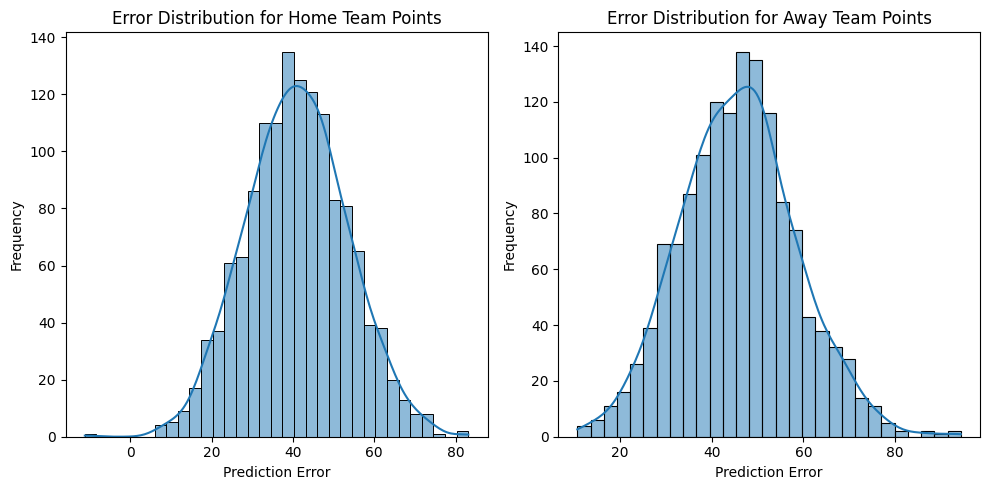

In [30]:
# Calculate errors
test_games['Error_home'] = test_games['PTS_home'] - test_games['PTS_home_pred']
test_games['Error_away'] = test_games['PTS_away'] - test_games['PTS_away_pred']

# Histogram of errors
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(test_games['Error_home'], kde=True)
plt.title('Error Distribution for Home Team Points')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test_games['Error_away'], kde=True)
plt.title('Error Distribution for Away Team Points')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


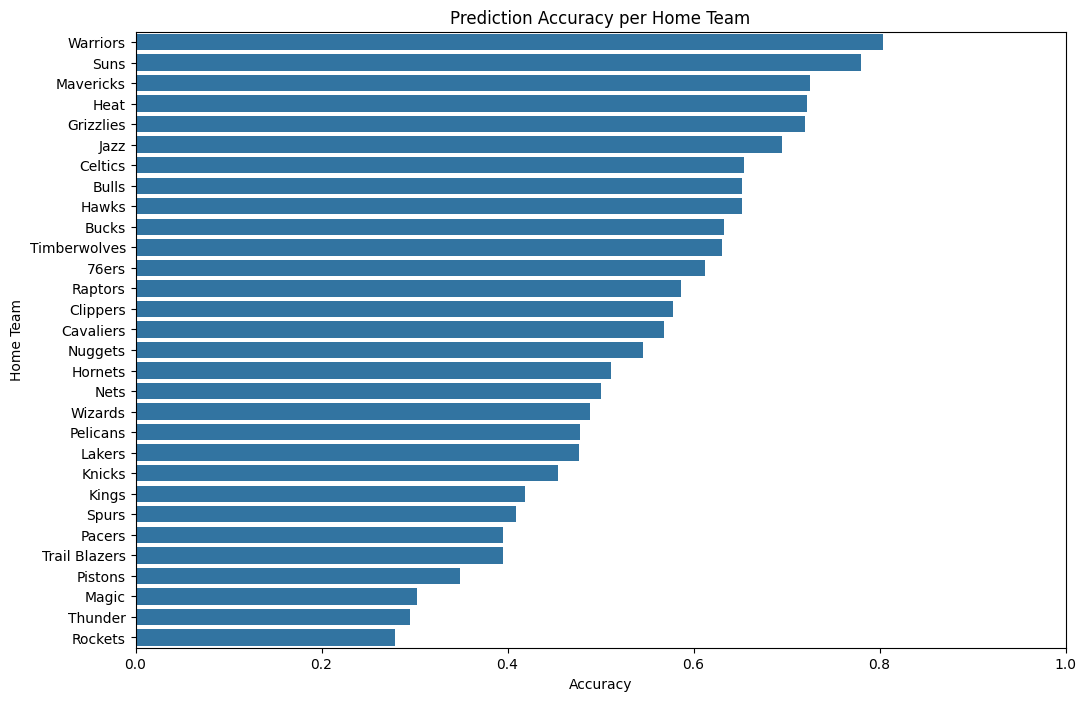

In [31]:
# Group by home team and calculate accuracy
team_accuracy = test_games.groupby('HOME_TEAM_NAME').apply(
    lambda x: accuracy_score(x['HOME_TEAM_WINS'], x['HOME_TEAM_WINS_pred'])
).reset_index(name='Accuracy')

# Sort by accuracy
team_accuracy = team_accuracy.sort_values(by='Accuracy', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=team_accuracy, x='Accuracy', y='HOME_TEAM_NAME')
plt.title('Prediction Accuracy per Home Team')
plt.xlabel('Accuracy')
plt.ylabel('Home Team')
plt.xlim(0, 1)
plt.show()


In [37]:
# Select relevant columns
output_columns = [
    'GAME_DATE_EST', 'HOME_TEAM_NAME', 'VISITOR_TEAM_NAME',
    'PTS_home_pred', 'PTS_away_pred', 'HOME_TEAM_WINS_pred'
]

predicted_results = test_games[output_columns]

# Round the predicted points
predicted_results['PTS_home_pred'] = predicted_results['PTS_home_pred'].round(1)
predicted_results['PTS_away_pred'] = predicted_results['PTS_away_pred'].round(1)




/var/folders/mz/57q3hbkj3gldm03rnq8cj4_c0000gn/T/ipykernel_42198/4114024738.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_results['PTS_home_pred'] = predicted_results['PTS_home_pred'].round(1)
/var/folders/mz/57q3hbkj3gldm03rnq8cj4_c0000gn/T/ipykernel_42198/4114024738.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_results['PTS_away_pred'] = predicted_results['PTS_away_pred'].round(1)


In [38]:
predicted_results

,GAME_DATE_EST,HOME_TEAM_NAME,VISITOR_TEAM_NAME,PTS_home_pred,PTS_away_pred,HOME_TEAM_WINS_pred
0,2022-06-16,Celtics,Warriors,70.1,62.3,1
1,2022-06-13,Warriors,Celtics,70.2,63.3,1
2,2022-06-10,Celtics,Warriors,70.1,62.3,1
3,2022-06-08,Celtics,Warriors,70.1,62.3,1
4,2022-06-05,Warriors,Celtics,70.2,63.3,1
...,...,...,...,...,...,...
1384,2021-10-04,Spurs,Jazz,70.2,63.3,1
1385,2021-10-04,Trail Blazers,Warriors,70.1,63.4,1
1386,2021-10-04,Kings,Suns,70.1,63.6,1
1387,2021-10-04,Clippers,Nuggets,70.1,63.3,1


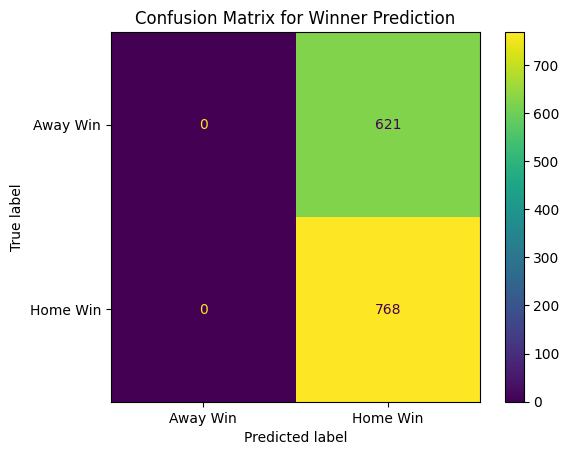

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(test_games['HOME_TEAM_WINS'], test_games['HOME_TEAM_WINS_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Away Win', 'Home Win'])
disp.plot()
plt.title('Confusion Matrix for Winner Prediction')
plt.show()
